# Procesamiento de Lenguaje Natural - **Representaciones Tradicionales de Texto**

Esta notebook presenta ejemplos de los diferentes aspectos relacionados con las formas tradicionales de representación de texto vistas en clase.

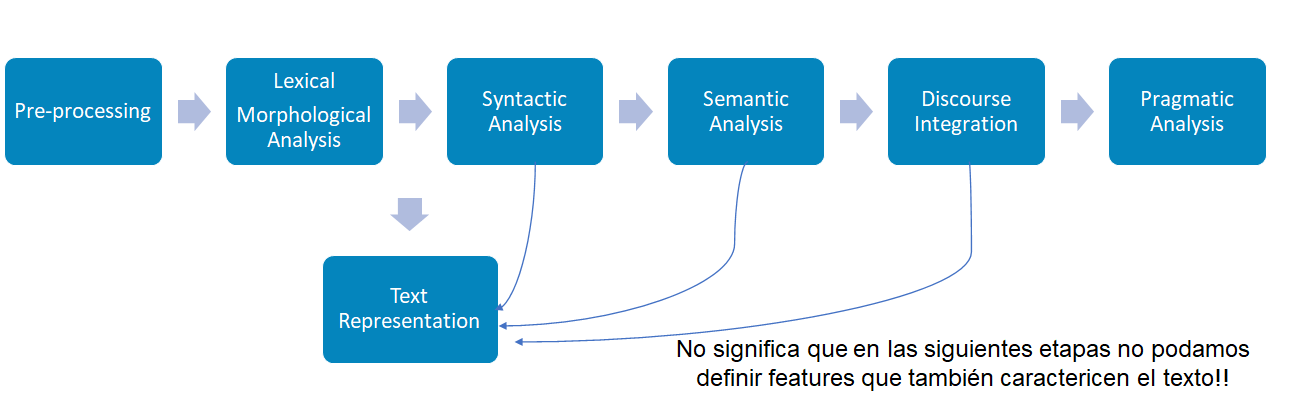

* Representaciones tradicionales
  * Bag of Words
  * Bag of N-Gram

Basadas en diferentes métricas de ponderación de características.

En caso de que los ejemplos lo requieran, los ejecutaremos tomando como base el siguiente corpus sencillo.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# building a corpus of documents
corpus = ['The sky is blue and beautiful.',
'Love this blue and beautiful sky!',
'The quick brown fox jumps over the lazy dog.',
"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
'I love green eggs, ham, sausages and bacon!',
'The brown fox is quick and the blue dog is lazy!',
'The sky is very blue and the sky is very beautiful today',
'The dog is lazy but the brown fox is quick!'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals',
'weather', 'animals']
# corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
print(corpus_df)

corpus_small = ['sky beautiful love blue sky.',
'love beautiful day',
'sky very beautiful today.'
]

labels_small = ['weather', 'weather', 'animals']

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

Podemos aplicar pre-procesamiento o no... En caso de que querramos aplicarlo, podemos usar el siguiente ```Transformer```:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import sent_tokenize
from nltk import wordpunct_tokenize
import re

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = nltk.corpus.stopwords.words('english')
       

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):

        return [
            ' '.join(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, sent):
        # una oración del documento
        sent = re.sub(r'[^a-zA-Z\s]', '', sent, re.I|re.A)
        new_sent = []
        for token in wordpunct_tokenize(sent):
             # aplicamos pre-procesamiento al token
             token = token.lower() 
             token = token.strip()
                
             # ignoramos el token si es un stopword
             if token in self.stopwords:
                continue
             new_sent.append(token)
        return new_sent


*Nota*: En la próxima clase/semana seguiremos trabajando con los ``Transformer`` y cómo implementarlos.

In [ ]:
processed_corpus = NLTKPreprocessor().transform(corpus)
print(processed_corpus)

Para pensar. En este ``PreProcessor`` estamos asumiendo que el documento vendrá en la forma de una lista de oraciones. Cómo deberíamos cambiarlo para que acepte un String? Y para que acepte cualquiera de las dos entradas?

## Modelos tradicionales 

* Basados en estadísticas.
* “Bolsas” no estructuradas de palabras.
* Los textos se representan como vectores donde cada dimensión representa un término distinto.
* Simples y efectivas.
* Pierden:
 * Semántica.
 * Estructura.
 * Contexto más allá de una o dos palabras cercanas.

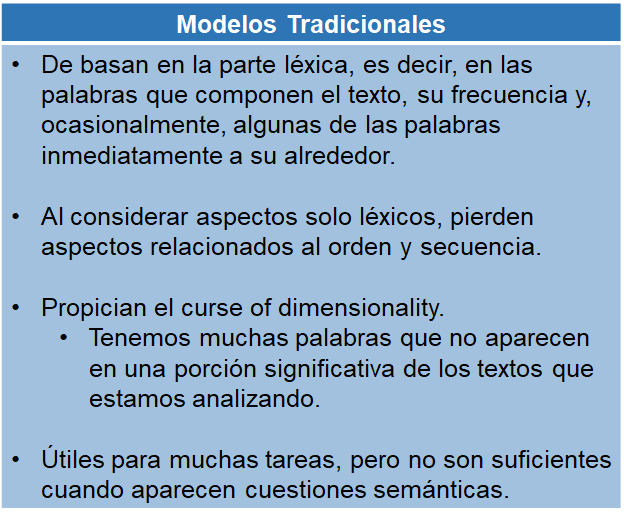

### Bag-of-words

El valor para cada feature puede ser:
* *Binario*. La palabra aparece o no en el texto.
* *Frecuencia*. Cuántas veces aparece la palabra en el documento?
* *Frecuencia Relativa*. Qué porcentaje del total de las palabras representa esta?

Vamos basarnos en NLTK ```CountVectorizer``` que incluye algunas opciones de pre-procesamiento. Por ejemplo, permite cambiar a lower case, eliminar acentos y eliminar stopwords. 

Para eliminar stopwords se le puede pasar la indicación de idioma o la lista que se desea usar. 

```min_df``` y ```max_df``` regulan la inclusión de términos con una frecuencia menor o mayor a las definidas. Las frencuencias pueden ser absolutas o expresar un porcentaje de documentos donde debe aparecer la feature. 

También se puede definir si se quiere usar valores binarios o no. Por defecto, calcula frecuencias. 

#### Frecuencia binaria

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv_matrix = cv.fit_transform(processed_corpus) 
print(cv_matrix) # dado que es una representación sparse, vamos a ver todo con 1

La matriz de características es tradicionalmente representada como una matriz *sparse* (rala) dado que la cantidad de características se incremental a medida que se agregan texto, dado que cada nueva palabra se convierte en una nueva feature.

En la salida anterior, cada par indica ```(texto, palabra)``` junto con la frecuencia de la ```palabra``` en el ```texto```.

Dicha representación sparse, puede ser transformada en una densa:

In [ ]:
# pueden aparecer warnings de memoria si la matriz a construir es "muy grande"
cv_matrix = cv_matrix.toarray()
cv_matrix

Ahora, la representación rala fue convertida en vectores numéricos en los que cada text es reprsentado por una fila de la matriz, y cada una de las columnas representa una palabra distinta. Luego, el valor para cada fila y columna se corresponde con la frecuencia de aparición de la palabra.

*Nota*. En algunos casos en los que se combinan ``Transformers`` hay que tener cuidado con las representaciones ralas por defecto dado que no todos las aceptan.

La representación de matriz se puede convertir en un ```DataFrame``` si quisieramos tener una representación más sencilla de entender. 

In [ ]:
vocab = cv.get_feature_names() # obtener todos las palabras en el corpus

pd.DataFrame(cv_matrix, columns=vocab, index=corpus) # mostrar las features de los documentos

#### Frecuencias absolutas


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_matrix = cv.fit_transform(processed_corpus) # obtener el bag of words en formato sparse

print(cv_matrix.toarray())

In [ ]:
vocab = cv.get_feature_names() # obtener todos las palabras en el corpus

pd.DataFrame(cv_matrix.toarray(),index=corpus,columns=vocab) # mostrar las features de los documentos

#### Frecuencia relativa

Ya no utilizamos el ``CountVectorizer``, sino que tenemos que utilizar el ``TfidfVectorizer`` con norma L1 y el uso de ``idf`` en ``False``.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tt = TfidfVectorizer(norm='l1',binary=False,use_idf=False,min_df=1,max_df=1.)

tt_matrix = tt.fit_transform(processed_corpus)
tt_matrix = tt_matrix.toarray()

vocab = tt.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab,index=processed_corpus)

### Bag of N-Grams Model

Una palabra es un token simple, también llamado “unigram” o “1-gram”. Luego, un N-gran es una colección de tokens que aparecen de forma continua en una oración. Por ejemplo, bi-gramas son los n-grams de orden 2, tri-gramas n-grams de orden 3, ...

Entonces, Bag of N-grams es una extensión de Bag of Words. En este caso, las features representan la secuencia de n-grams.

La creación de esta representación es similar a la de Bag of Words. ```CountVectorizer``` cuenta con un parámetro (```ngram_range```) que permite definir de qué tamaño son los n-grams a considerar. Dicho parámetro recibe la tupla ```(min_x, max_x)``` que indica el tamaño mínimo y máximo inclusive. Por defecto, toma el valor ```(1,1)```.


In [ ]:
bv = CountVectorizer(ngram_range=(2,2)) # el CountVectorizer de antes, pero con parámetros nuevos para definir los n-grams. 
# En este caso toma solo los que tienen dos grams

bv_matrix = bv.fit_transform(processed_corpus)
bv_matrix = bv_matrix.toarray()

vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab,index=processed_corpus)

In [ ]:
bv = CountVectorizer(ngram_range=(1,3)) # acá estamos tomando de los términos individuales hasta las secuencias de longitud 3

bv_matrix = bv.fit_transform(processed_corpus)
bv_matrix = bv_matrix.toarray()

vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab,index=processed_corpus)

## Métricas de ponderación

* Binaria, frecuencia, frecuencia relativa son formas de ponderación (o pesado) de características.

* Los métodos de ponderación intentan asignar pesos apropiados a las características (términos) de forma que las más “importantes” reciban mayores pesos en la representación


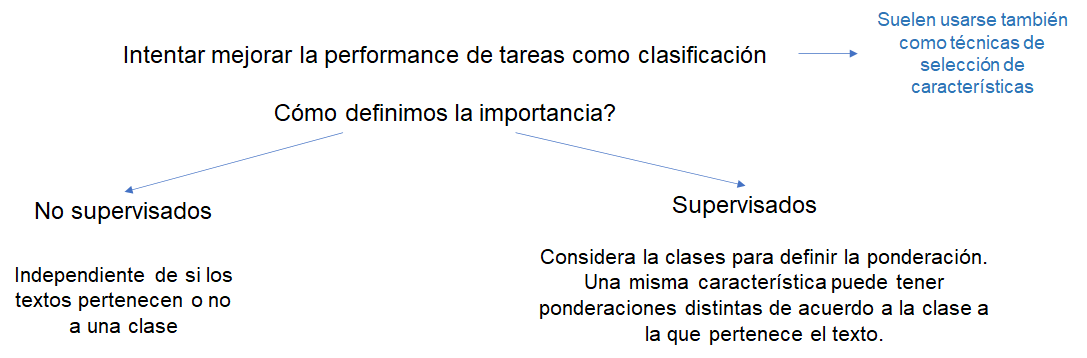

#### No supervisadas
  * No requieren conocer la clase a la que pertenecen los textos.
  * La mayoría de los métodos se basan en la frecuencia de aparición de los términos (TF).
  * Suelen funcionar adecuadamente con textos “tradicionales”.
  * No suelen ser adecuados con textos con longitud limitada, ralos y ruido, pero son comunmente utilizados.




##### TF-IDF

* Los vectores generados con los modelos anteriores están basados en estadísticas calculadas sobre cada uno de los textos de forma individual.
 * Puede haber términos que aparecen en todos los documentos.
 * Esos términos pueden parecer más importantes que otros que aparecen en pocos documentos.

* Palabras que no ocurren en todos los documentos pueden ser relevantes para posteriores tareas.
 * Por ejemplo, clasificación.

Para esta transformación, se puede usar el ```TfidfVectorizer```. Tiene diversos parámetros:
* ```norm```. Define si el valor de la métrica será normalizado o no. Por defecto, normaliza con la media Euclideana, pero también se puede usar la norma-1 (```l1```, la que usamos antes para obtener la frecuencia relativa) o max (```max```).
* ```use_idf```. Si incluir el término correspondiente al idf. Por default es ```True```.
* ```smooth_idf```. Agrega uno a las frecuencias de los documentos para evitar dividir por cero. Por default es ```True```.
* ```sublinear_tf```. Aplicar escalado a tf, reemplazándolo por ```1 + log(tf)```.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tt = TfidfVectorizer(norm='l2')

tt_matrix = tt.fit_transform(corpus)

tt_matrix = tt_matrix.toarray()

vocab = tt.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab,index=processed_corpus)

In [ ]:
tt = TfidfVectorizer(norm='max') # cambiamos la forma de normalización

tt_matrix = tt.fit_transform(processed_corpus)

tt_matrix = tt_matrix.toarray()

vocab = tt.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab,index=processed_corpus)

In [ ]:
tt = TfidfVectorizer(use_idf=False) # sacamos el uso del idf

tt_matrix = tt.fit_transform(processed_corpus)

tt_matrix = tt_matrix.toarray()
vocab = tt.get_feature_names()

pd.DataFrame(np.round(tt_matrix, 2), columns=vocab,index=processed_corpus)

Soporta también todos los parámetros de pre-procesamiento de ``CountVectorizer``. El uso de este transformer es igual a utilizar ``CountVectorizer`` seguido de ``TfidfTransformer``.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(processed_corpus)

tt = TfidfTransformer(norm='l2', use_idf=True)

tt_matrix = tt.fit_transform(cv_matrix)

tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names()
pd.DataFrame(np.round(tt_matrix, 2), columns=vocab,index=processed_corpus)

#### Supervisadas
  * Requieren conocer la clase a la que pertenecen los textos.
  * La mayoría de los métodos se basan en combinaciones de TF con métricas supervisadas.
  * Las metricas suelen considerar cálculos estadísticos.
  * Pueden calcularse a partir de la relevancia dada por los modelos de clasificación.

Vamos a ejemplificar con Information Gain

##### Information Gain (IG)

* Mide la información obtenida a partir de conocer la información de la presencia o ausencia de un término en un texto.
* Requiere el cálculo de propiedades condicionales y entropía.
* Su valor es afectado por incremento de la dependencia entre los términos y la entropía.
* Términos con baja entropía reciben valores bajos, aún cuando se encuentren relacionados con la clase.

* Gain Ratio (GR) es la version normalizada de IG.
* Al normalizar por la entropía disminuye el bias por los términos frecuentes.



En algunas fuentes la definen de la misma que Information Gain.
La diferencia es la simetría.
Mientras que Mutual Information solo considera los términos positivos, Information Gain considera todos.


Como mencionamos en la clase, estas métricas también son utilizadas para realizar Feature Selection (como veremos más adelante) y son combinadas con el resultado de TF.

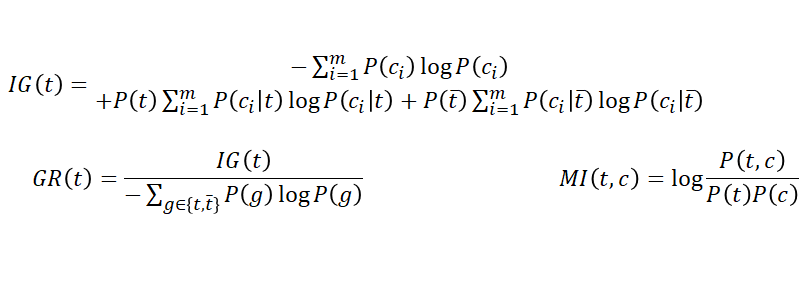

Primero, vamos a ver como obtener la Información Mutua / Information Gain con Sklearn sin tener que calcularla manualmente nosotros.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer

# primero necesitamos transformar el corpus calculando las frecuencias de aparición
cv = CountVectorizer()
X_dtm = cv.fit_transform(processed_corpus)
X_dtm = X_dtm.toarray()

# # luego podemos calcular el mutual information/information gain de los términos --> De acuerdo con sklearn son lo mismo
mutual_info =  mutual_info_classif(X_dtm, labels, discrete_features=True)

# # imprimimos el valor junto con la feature
res = dict(zip(cv.get_feature_names(),
              mutual_info
               ))
print(res)

Eso nos da el valor de Mutual Information para cada una de las features, pero no nos crea la representación de cada documento. 

Así como utilizamos el ``CountVectorizer``, ahora vamos a modificarlo para crear nuestra propia versión de un ``Vectorizer``. La ventaja de esta definición es que luego, vamos a poder utilizarlo en los pipelines de procesamiento y clasificación que definamos.

*Nota.* Más adelante vamos a trabajar un poco más sobre ``Pipelines`` y ``Transformers``.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from operator import itemgetter
import array
import scipy.sparse as sp

class MutualInformationVectorizer(BaseEstimator, TransformerMixin): # post transformado a su mutual information
  def __init__(self, stopwords = None, lower=True):
    self.mutual_information = None # nuestra instancia que se encargá de calcular el information gain para cada feature
    self.cv = CountVectorizer(stop_words=stopwords,lowercase=lower) # definimos el pre-procesamiento base para nuestro vectorizer
    self.vocabulary_ = None

  def fit(self,X,y): # si quisiéramos trabajar con otra métrica, este sería el comportamiento que deberíamos cambiar
    X_dtm = self.cv.fit_transform(X) # hace lo mismo que hicimos antes, transformamos nuestros documentos completos en la representación que requiere mutual_information.
    X_dtm = X_dtm.toarray()
    self.mutual_information =  mutual_info_classif(X_dtm, y, discrete_features=True)
    self.vocabulary_ = self.cv.vocabulary_
    return self
  
  def get_feature_names(self): # acá se podría también llamar a self.cv.get_feature_names()
     return [t for t, i in sorted(self.vocabulary_.items(),
                                     key=itemgetter(1))]

  def transform(self,X):
    X = self._count_vocab(X, fixed_vocab=True) # construimos la representación que necesitamos
    return X
  
  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

  def _count_vocab(self, raw_documents, fixed_vocab): # va a contruir la matriz sparse que retornaba el CountVectorizer
        if fixed_vocab:
            vocabulary = self.vocabulary_
      
        j_indices = []
        indptr = []

        values = array.array(str("f"))
        indptr.append(0)
        for doc in raw_documents:
            feature_counter = {}
           
            for feature_idx in self.cv.transform([doc]).nonzero()[1]: # usamos el cv para que nos devuelva las features del documento basándonos en el corpus con el que hicimos el fit
              try:
                feature_counter[feature_idx] = self.mutual_information[feature_idx]
              except KeyError:
                # en este caso no sucede, pero podría pasar que los textos a transformar nos dejen features que no tenemos, con lo cual hay que descartarlas
                continue
                
            j_indices.extend(feature_counter.keys())
            values.extend(feature_counter.values())
            indptr.append(len(j_indices))

        indices_dtype = np.float64 # terminamos de armar nuestra matriz sparse
        j_indices = np.asarray(j_indices, dtype=indices_dtype)
        indptr = np.asarray(indptr, dtype=indices_dtype)
        values = np.asarray(values, dtype=np.float64)
        
        X = sp.csr_matrix((values, j_indices, indptr),
                          shape=(len(indptr) - 1, len(vocabulary)),
                          dtype=np.float64)
        X.sort_indices()
        return X

Una vez que lo definimos, ahora lo podemos probar! 

Simplemente lo invocamos con nuestro corpus y los labels correspondientes y tenemos el ``Vectorizer`` especializado.

In [ ]:
mi = MutualInformationVectorizer()
fit = mi.fit_transform(processed_corpus,labels)

print(fit)

Hasta acá tenemos un ``Vectorizer`` que nos retorna para cada feature su valor de Información Mutua. Pero habíamos dicho que, en general, las métricas supervisadas, hacen un cálculo de TF * Métrica.

Entonces, vamos a modificar nuestro vectorizer para realizar eso!

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from operator import itemgetter
import array
import scipy.sparse as sp

class TFMutualInformationVectorizer(BaseEstimator, TransformerMixin): # post transformado a su mutual information
  def __init__(self, stopwords = None, lower=True):
    self.mutual_information = None # nuestra instancia que se encargá de calcular el information gain para cada feature
    self.cv = CountVectorizer(stop_words=stopwords,lowercase=lower) # definimos el pre-procesamiento base para nuestro vectorizer, si quisieramos utilizar la frecuencia relativa, deberíamos cambiar el vectorizer de base
    self.vocabulary_ = None

  def fit(self,X,y): 
    X_dtm = self.cv.fit_transform(X) # hace lo mismo que hicimos antes, transformamos nuestros documentos completos  en la representación que requiere mutual_information.
    X_dtm = X_dtm.toarray()
    self.mutual_information =  mutual_info_classif(X_dtm, y, discrete_features=True)
    self.vocabulary_ = self.cv.vocabulary_
    return self
  
  def get_feature_names(self): # acá se podría también llamar a self.cv.get_feature_names()
     return [t for t, i in sorted(self.vocabulary_.items(),
                                     key=itemgetter(1))]

  def transform(self,X): # esto es lo único que cambiamos
    sparse_matrix = self.cv.transform(X).astype('float') # tomamos de base la matriz que nos genera el vectorizer dado que necesitamos los valores de base.

    for el in zip(sparse_matrix.nonzero()[0],sparse_matrix.nonzero()[1]):
      sparse_matrix[el[0],el[1]] = sparse_matrix[el[0],el[1]] * self.mutual_information[el[1]] # al valor original, le multiplicamos el valor de mutual information

    sparse_matrix.sort_indices()
      
    return sparse_matrix
  
  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)


Ahora, lo aplicamos:

(En este caso va a cambiar un único valor respecto a la anterior dado que todas las features menos 1 aparecen una única vez en los documentos)

In [ ]:
mi = TFMutualInformationVectorizer()
fit = mi.fit_transform(processed_corpus,labels)
print(fit)

Así como trabajamos con Información Mutua, podemos hacerlo para el resto de las métricas que vimos en clase! 

En el caso de ``chi2``, sklearn también la trae implementada. Lo único que habría que cambiar es el cálculo de esa métrica.

# Extra: Modelos basados en grafos

* Los grafos han sido utilizados en IR (information retrieval) para encontrar relaciones y proponer esquemas de pesos significativos.
  * Ej. PageRank.

* Desafían la independencia de los tokens y los esquemas de ponderado por frecuencias que toman en cuenta la independencia de palabras, orden y distancia.

* Usos:
  * Desambiguación.
  * Entailment.
  * Summarization.
  * Relation extraction.
  * Narrative fluency

Tenemos el $G = (V, E)$.

Los **nodos** se pueden corresponder con:
* Párrafos.
* Oraciones.
* Frases.
* Palabras.
* Sílabas.
* Chars.

Los **arcos** pueden capturar distintos tipos de relaciones:
* Co-ocurrencias de palabras en una determinada ventana.
* La dirección del arco indica el orden de las palabras.
* Relaciones sintácticas.
* Análisis sintáctico.
* Relaciones semánticas.
  * Por ejemplo, sinónimos, antónimos, …

Algunas consideraciones:

* **Grafo dirigido vs. no dirigido**
  * En grafos no dirigidos se representa la relación de forma “bilateral”.
  * Grafos dirigidos permiten preservar el flujo del texto.


* **Grafo ponderado vs. sin ponderar**
  * Todas las relaciones valen lo mismo.
  * El peso de la relación varia de acuerdo con la cantidad de veces que la relación ocurrió.
  * Considerar que muchas de las técnicas standard de grafos suelen estar diseñadas para grafos no pesados.

* **Tamaño de la ventana**
  * Se pueden considerer ventanas de diferentes tamaños.
  * En algunos estudios recomiendan entre 6 y 30.
  * A manor ventana, mayor densidad en el grafo.
  * Modifica el impacto de la dependencia de término.
  * Tener en cuenta que el tamaño de la Ventana afecta de modo lineal la complejidad temporal.

* **Alternativas de ponderado**
  * Podemos utilizar alternativas derivadas de métricas de grafos.
  * Por ejemplo: degree-based, eigenvector, betweenness, closeness.

En este ejemplo, vamos a transformar el siguiente fragmento en un grafo, considerando una ventana de tamaño 3.

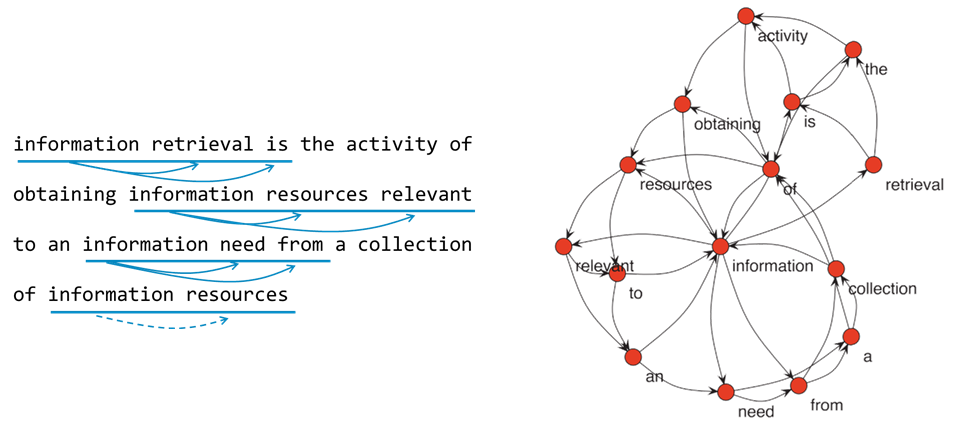

Vamos a basarnos en la biblioteca [Graph of Words](https://pypi.org/project/graph-of-words/). 

La implementación usa ``nltk`` y ``NetworkX``.

In [ ]:
pip install graph-of-words

In [ ]:
import nltk # en caso de que no los tengamos importados de arriba
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
from graph_of_words import GraphOfWords

graph = GraphOfWords(window_size=3)
graph.build_graph( 
    corpus,
    remove_stopwords=False, # si se quieren eliminar stopwords en un texto que no está en inglés, hay que setear además el idioma
    workers=4
)

In [ ]:
graph.display_graph() # mostramos el grafo
graph.write_graph_edges('edges_list.txt') # guardamos los arcos

La biblioteca es muy simple y no tiene mucha flexibilidad. Por ejemplo, si quisiéramos hacer algo más complejo que involucre en lugar de las palabras, los POS de cada una de ellas, deberíamos primero procesar el texto y luego dárselo para la construcción del grafo. 

También podríamos optar por implementar nosotros el soporte del grafo.

*Nota:* La implementación se va a basar en ``NetworkX``. En caso de que no estén familiarizados con la biblioteca, pueden revisar la notebook de *Introducción a NetworkX* que tienen disponible.

In [ ]:
import math
import re
from collections import Counter
from collections import defaultdict
from statistics import mean

import networkx as nx
import numpy as np
import sklearn
import spacy

In [ ]:
class TextGraph():
    nlp = None
    graph = None
    lemma = None

    def __init__(self, text, **kwargs):
        self.nlp = spacy.load(kwargs.get('model', 'es_core_news_sm')) # por default vamos a cargar el modelo en español de spacy, requiere que ya esté descargado
        self.lemma = kwargs.get('lemma', False)
        self.graph = self._text2graph(text,kwargs.get('window',1))

    def statistics(self):
        res = {}
        res['number_of_nodes'] = self.graph.number_of_nodes()
        res['number_of_edges'] = self.graph.number_of_edges()
        
        res['PE'] = sum(1 for x in self.graph.edges(data=True) if x[2]['weight'] > 1) # parallel edges: sum of all parallel edges linking the same pair of nodes
        res['LCC'] = nx.algorithms.components.number_weakly_connected_components(self.graph)
        res['LSC'] = nx.algorithms.components.number_strongly_connected_components(self.graph)

        degrees = [x[1] for x in self.graph.degree()]
        res['degree_average'] = np.mean(degrees)
        res['degree_std'] = np.std(degrees)

        adj_matrix = nx.linalg.adj_matrix(self.graph).toarray()
        adj_matrix2 = np.dot(adj_matrix, adj_matrix)
        adj_matrix3 = np.dot(adj_matrix2, adj_matrix)

        res['L1'] = np.trace(adj_matrix)
        res['L2'] = np.trace(adj_matrix2)
        res['L3'] = np.trace(adj_matrix3)

        return res

    def _text2graph(self, text, window):
        words = self.process_text(text)
        gr = nx.DiGraph()
        edge_count = Counter([(words[start],words[start+end],1) for start in range(len(words)) for end in range(1,window) if start+end < len(words)])
        gr.add_weighted_edges_from((k[0], k[1], v) for k, v in edge_count.items())
        return gr

    def process_text(self, text): # implementación básica, podemos subclasear y armar la implementación que querramos
        processed_text = self.nlp(text.lower())
        words = [t.text.strip() for t in processed_text if not t.is_punct]
        return words

In [ ]:
spacy.cli.download('es_core_news_sm')

In [ ]:
dream = "Harry Potter y la piedra filosofal"

naive = TextGraph(dream,window=3)

naive.statistics()

In [ ]:
import matplotlib.pyplot as plt
limits = plt.axis("off") 

pos = nx.kamada_kawai_layout(naive.graph)
nx.draw_networkx(naive.graph, pos=pos, node_size = 400)